<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skip connection in  [Resnet](https://arxiv.org/abs/1512.03385)

In ResNet architectures, a skip connection, often referred to as a "skip layer," provides a shortcut path for the input tensor to bypass one or more layers in the network.  Instead of directly feeding the output of a layer to the next, the skip connection adds the input tensor to the output of the layer.  Mathematically, this looks like:

`Output = F(Input) + Input`

where `F` represents the transformations performed by one or more layers within the residual block, and `Input` is the activation from the previous layer.

### Benefits of skip connection:

* **Addressing Vanishing/Exploding Gradients:**  The skip connection facilitates the flow of gradients during backpropagation, helping to mitigate the vanishing or exploding gradient problem. The direct path for the gradients allows them to propagate more easily through the network, especially in deep architectures where these problems are more pronounced.  The gradients have an easier path to update weights in earlier layers, allowing the network to learn effectively.

* **Enabling Deeper Networks:**  By easing gradient flow, skip connections enable the training of significantly deeper networks.  Deeper networks, in theory, have greater capacity to learn complex features. Without skip connections, very deep networks are difficult or impossible to train due to vanishing gradients.

* **Improved Optimization:** Skip connections are not simply a shortcut for the data, but a mechanism to optimize the network. The network learns *residual functions* — the difference between the desired output and the input — rather than learning the complete mapping directly.  This allows the network to learn incremental improvements on top of what's already been learned.


NB: The skip connection is a crucial component of ResNet architectures, allowing for the construction and training of extremely deep networks by improving gradient flow and enabling the learning of residual mappings. This has revolutionized the field of Computer Vision which has become the state of the art model and showed competitive results on [Imagenet](https://www.image-net.org/).


## Schematic figure of Resnet (source:Wikepedia)

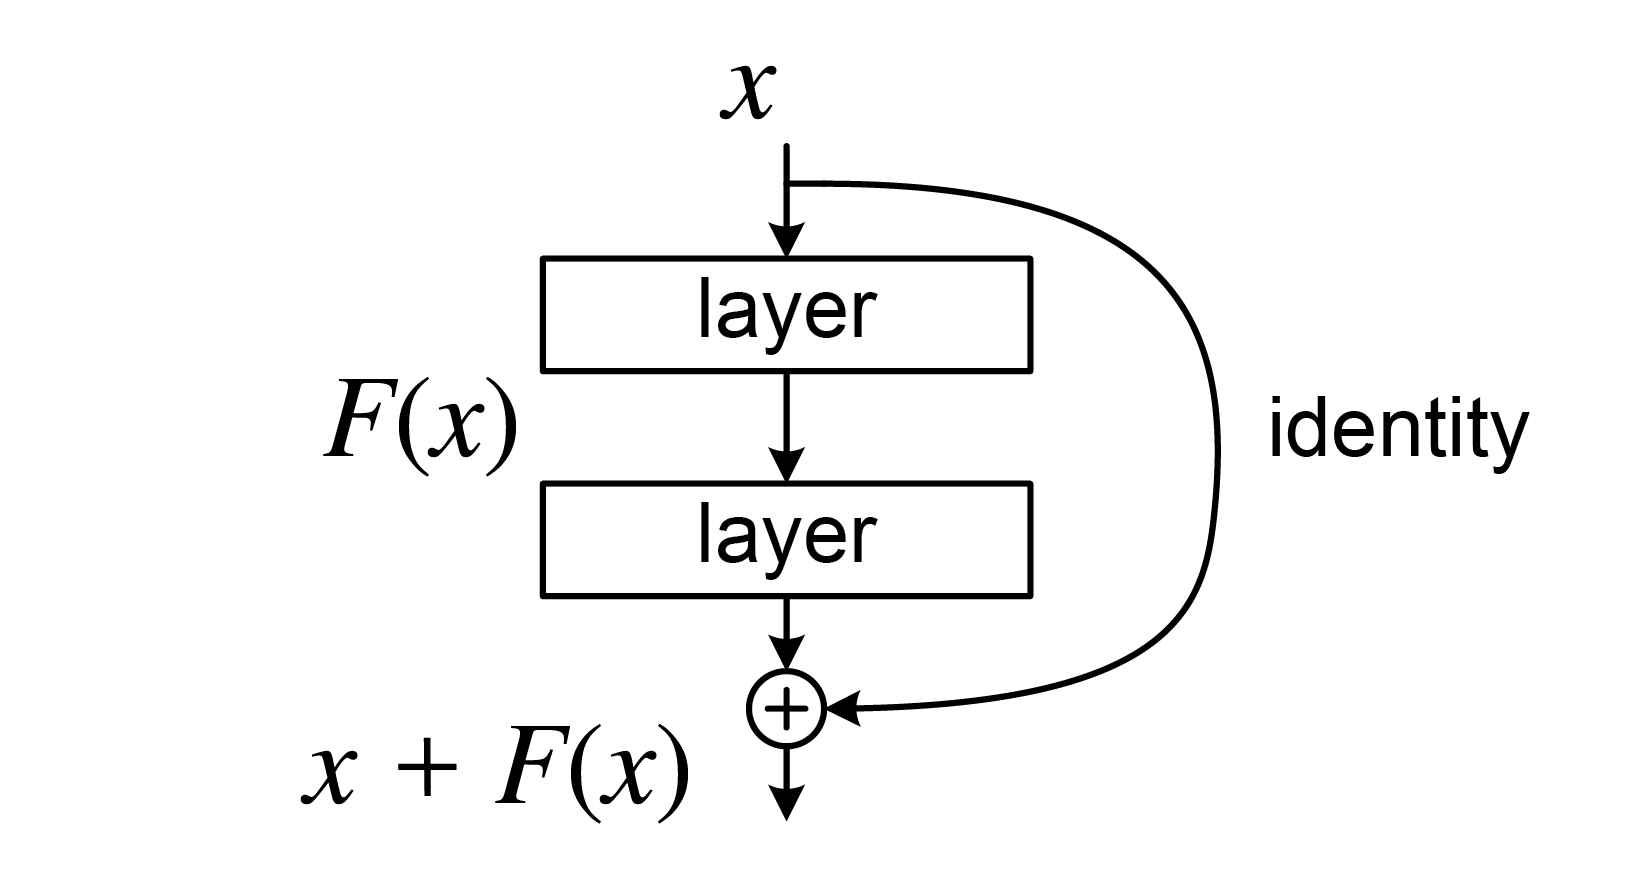

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [60]:
## Write a torch module for one skip layer as shown in the figure below

## A layer in the figure represent a sequential layer of conv layer -> batchnorm -> Activation function(ReLu)
import torch
## We expect by now, you have learnt about different arguments of torch.nn.Conv2D module like in_channels, out_channels, kernel_size, stride, and padding

##import modules whichever required

class SkipLayer(torch.nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding) -> None:
    super().__init__()
    self.pre_skip_layer = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
      torch.nn.BatchNorm2d(out_channels),
      torch.nn.ReLU()

    )

  def forward(self,x):
    #write your code here
    return self.pre_skip_layer(x) +x
    pass


In [3]:
## Test your module

# 16-batchsize
# 4-channels
# 28 \times 28 - height \times width

random_sample = torch.randn((16,4,28,28))
skip_layer = SkipLayer(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)


print(skip_layer(random_sample).shape)

torch.Size([16, 4, 28, 28])


## Torchvision's Resnet [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
Now, that you have learnt what is skip connection module, now its time to use a Resnet module to our classification tasks on SAT-6 dataset.

Try to replace our predefined CNN with Resnet. Use already available Resnet module

Hints: The Resnet module from torchvision is developed for RGB images where input image has 3 channels. Please try to change it.

In [4]:
import torch
import torch.nn as nn
import torchvision.models as model


In [62]:
import torchvision.models as model

class ResNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=6):
        super(ResNet,self).__init__()
        self.model = model.resnet18(weights=None)
        # Only first layer have to be adapted to 4 instead of 3 input channels
        self.model.conv1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


I Just copied part of the Dataset code from the prevoius exercise


In [6]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-06-02 11:57:46--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863.67M  18.9MB/s    in 47s     

2025-06-02 11:58:34 (18.2 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-06-02 11:58:35--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv’

y_test_sat6.csv     100%[===================>] 949.22K  1.08MB/s    in 0.9s    

2025-06-02 11:58

In [7]:
import pandas as pd


# load the csv file with the image data. Each row belongs to one sample.
# Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28×28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv", header=None)
landcover_df


,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,...,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,...,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,...,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,...,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,...,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,...,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,...,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,...,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,...,111,15,49,52,97,11,47,56,102,9


In [8]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')


             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


In [9]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv", header=None)
print(labels_df)

# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values


       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


In [10]:
import numpy as np

# change to npy arrays for dataloader to train resnet
X = landcover_df.values.astype(np.float32).reshape(-1, 4, 28, 28)
y = np.argmax(labels_df.values, axis=1)


In [18]:
num_train = 1000
num_test = 100
train_idx = []
test_idx = []

for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1

    selected = np.random.choice(np.where(class_idx.values)[0], size=num_train + num_test, replace=False)
    train_idx.extend(selected[:num_train])
    test_idx.extend(selected[num_train:])

print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')

# Shuffle train and test indices
train_idx = np.random.permutation(train_idx)
test_idx = np.random.permutation(test_idx)

# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]



number of train indices: 6000, number of test indices: 600


In [15]:
print(train_y.shape)


(6000,)


In [55]:
import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import numpy as np

train_X = train_X.astype(np.float32).reshape(-1, 4, 28, 28)
test_X = test_X.astype(np.float32).reshape(-1, 4, 28, 28)


class Dataset(TorchDataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = Dataset(train_X, train_y)
val_dataset = Dataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [56]:
# Train method generated by ChatGPT
def train_model(model, train_loader, val_loader, criterion, optimizer, device='cpu', epochs=10, print_every=100):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\n Epoch {epoch+1}/{epochs}")

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (batch_idx + 1) % print_every == 0:
                avg_loss = running_loss / total
                acc = correct / total
                print(f"  Step [{batch_idx+1}/{len(train_loader)}]  Loss: {avg_loss:.4f}  Acc: {acc:.4f}")

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                v_loss = criterion(val_outputs, val_labels)
                val_loss += v_loss.item() * val_images.size(0)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss_avg = val_loss / val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1} Done — Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f} | Val Loss: {val_loss_avg:.4f}  Val Acc: {val_acc:.4f}")


In [57]:
print("train_y:", train_y[:10])
print("train_y shape:", train_y.shape)
print("unique labels:", np.unique(train_y))

train_y: [2 1 0 4 0 0 1 3 3 1]
train_y shape: (6000,)
unique labels: [0 1 2 3 4 5]


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, criterion, optimizer, device=device, epochs=10)



 Epoch 1/10
Epoch 1 Done — Train Loss: 0.3504  Acc: 0.8697 | Val Loss: 0.2306  Val Acc: 0.9017

 Epoch 2/10
Epoch 2 Done — Train Loss: 0.2041  Acc: 0.9238 | Val Loss: 0.5533  Val Acc: 0.8117

 Epoch 3/10
Epoch 3 Done — Train Loss: 0.1650  Acc: 0.9392 | Val Loss: 0.4975  Val Acc: 0.8650

 Epoch 4/10
Epoch 4 Done — Train Loss: 0.1490  Acc: 0.9500 | Val Loss: 0.4839  Val Acc: 0.8833

 Epoch 5/10
Epoch 5 Done — Train Loss: 0.1459  Acc: 0.9493 | Val Loss: 0.4285  Val Acc: 0.8333

 Epoch 6/10
Epoch 6 Done — Train Loss: 0.1244  Acc: 0.9578 | Val Loss: 0.5810  Val Acc: 0.8400

 Epoch 7/10
Epoch 7 Done — Train Loss: 0.1696  Acc: 0.9448 | Val Loss: 0.1866  Val Acc: 0.9433

 Epoch 8/10
Epoch 8 Done — Train Loss: 0.1096  Acc: 0.9620 | Val Loss: 0.0866  Val Acc: 0.9717

 Epoch 9/10
Epoch 9 Done — Train Loss: 0.1046  Acc: 0.9625 | Val Loss: 0.1202  Val Acc: 0.9467

 Epoch 10/10
Epoch 10 Done — Train Loss: 0.1015  Acc: 0.9645 | Val Loss: 0.1833  Val Acc: 0.9200


Trained again only for 4 epoch because validfation loss looks best

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, criterion, optimizer, device=device, epochs=4)



 Epoch 1/4
Epoch 1 Done — Train Loss: 0.4029  Acc: 0.8542 | Val Loss: 0.6456  Val Acc: 0.7517

 Epoch 2/4
Epoch 2 Done — Train Loss: 0.2330  Acc: 0.9188 | Val Loss: 0.5627  Val Acc: 0.7700

 Epoch 3/4
Epoch 3 Done — Train Loss: 0.1864  Acc: 0.9320 | Val Loss: 0.4050  Val Acc: 0.8750

 Epoch 4/4
Epoch 4 Done — Train Loss: 0.1491  Acc: 0.9475 | Val Loss: 0.1187  Val Acc: 0.9667


In [64]:
import numpy as np
import torch
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device='cpu', num_classes=6):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    kappa = cohen_kappa_score(all_labels, all_preds)
    print(f"Kappa-Score: {kappa:.4f}")
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return kappa


Kappa-Score: 0.9600


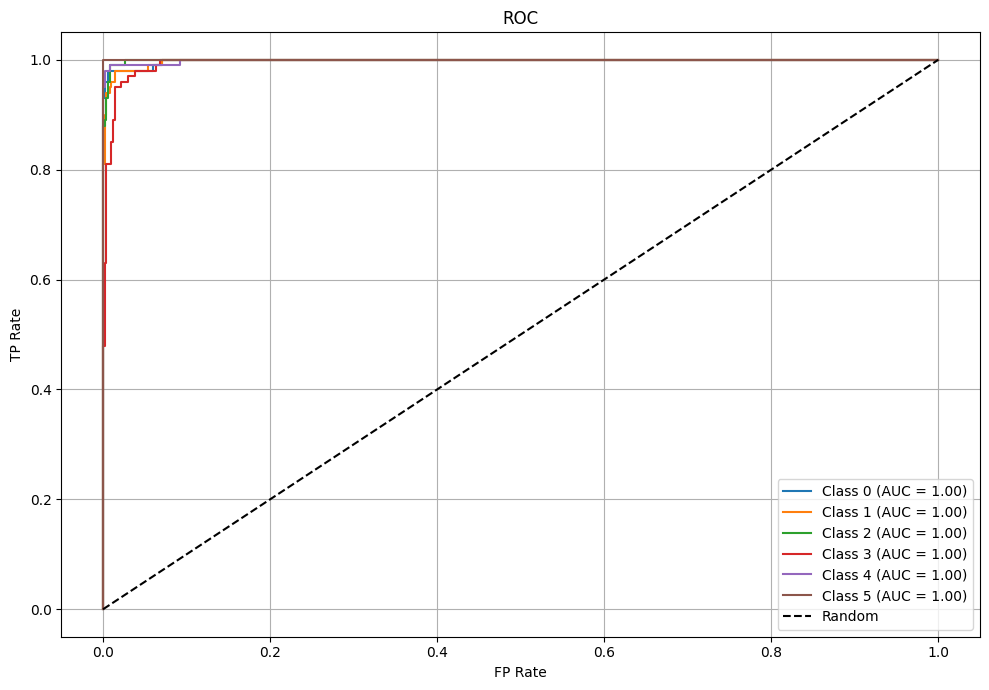

In [65]:
kappa_score = evaluate_model(model, val_loader, device='cuda', num_classes=6)
